In [1]:
import datetime
import pickle
import io
from libs.unionfind import UnionFind
from libs.SOM import SOM
import math
import numpy as np
import random as rnd
import tensorflow as tf

%matplotlib inline
from matplotlib import pyplot as plt

float_format = "{:.4f}"

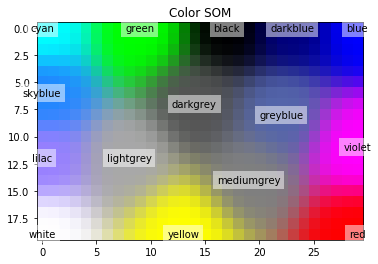

In [3]:
###################################################
# # Test of SOM method
# # Training inputs for RGBcolors
# colors = np.array(
#      [[0., 0., 0.],
#       [0., 0., 1.],
#       [0., 0., 0.5],
#       [0.125, 0.529, 1.0],
#       [0.33, 0.4, 0.67],
#       [0.6, 0.5, 1.0],
#       [0., 1., 0.],
#       [1., 0., 0.],
#       [0., 1., 1.],
#       [1., 0., 1.],
#       [1., 1., 0.],
#       [1., 1., 1.],
#       [.33, .33, .33],
#       [.5, .5, .5],
#       [.66, .66, .66]])
# color_names = \
#     ['black', 'blue', 'darkblue', 'skyblue',
#      'greyblue', 'lilac', 'green', 'red',
#      'cyan', 'violet', 'yellow', 'white',
#      'darkgrey', 'mediumgrey', 'lightgrey']

# # Train a 20x30 SOM with 400 iterations
# som = SOM(20, 30, 3, 400)
# som.train(colors)
 
# # Get output grid
# image_grid = som.get_centroids()
 
# # Map colours to their closest neurons
# mapped = som.map_vects(colors)
 
# # Plot
# plt.imshow(image_grid)
# plt.title('Color SOM')
# for i, m in enumerate(mapped):
#     plt.text(m[1], m[0], color_names[i], ha='center', va='center',
#              bbox=dict(facecolor='white', alpha=0.5, lw=0))
# plt.show()

##############################################################
# # Training inputs for images z
# train_images_3_z = np.load('model/train_images_3_z.npy')
 
# # Train a 120x120 SOM with 100 iterations
# som = SOM(120, 120, 640, 100)
# som.train(train_images_3_z)
 
# # Get som weight grid and save it to 'model/som_weight_grid.npy'
# som_weight_grid = som.get_centroids()
# som_weight_grid = np.asarray(som_weight_grid)
# print('som_weight_grid:', som_weight_grid.shape)
# np.save('model/som_weight_grid.npy', som_weight_grid)

In [2]:
# %%
# load training image_1, training cmd_1, and training images_1_z
train_images = np.load('train_images3.npy')
train_cmds = np.load("train_cmds3.npy")
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
train_images_z = np.load('model/train_images_3_z.npy')
print(train_images.shape, train_cmds.shape, train_steps.shape, train_angles.shape, train_images_z.shape)

# load training image_2, training cmd_2, and and training images_2_z
# train_images_2 = np.load('train_images2.npy')
# train_cmds_2 = np.load("train_cmds2.npy")
# train_steps_2 = train_cmds_2[:, 0]
# train_angles_2 = train_cmds_2[:, 1]
# train_images_2_z = np.load('model/train_images_2_z.npy')
# print(train_images_2.shape, train_cmds_2.shape, train_steps_2.shape, train_angles_2.shape, train_images_2_z.shape)

# load test images, related commands and test images_z
test_images = np.load('test_images.npy')
test_cmds = np.load('test_cmds.npy')
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
test_images_z = np.load('model/test_images_z.npy')
print(test_images.shape, test_cmds.shape, test_xs.shape, len(test_x_set), test_ys.shape, len(test_y_set),
      test_angles.shape, len(test_angle_set), test_images_z.shape)
# print(test_x_set, test_y_set, test_angle_set)

(60000, 40, 320, 1) (59999, 3) (59999,) (59999,) (60000, 640)
(12096, 40, 320, 1) (12096, 3) (12096,) 24 (12096,) 14 (12096,) 36 (12096, 640)


(array([  5.00000000e+00,   3.10000000e+01,   1.08000000e+02,
          2.29000000e+02,   3.56000000e+02,   4.27000000e+02,
          4.92000000e+02,   6.22000000e+02,   6.93000000e+02,
          8.63000000e+02,   1.12300000e+03,   1.25100000e+03,
          1.41500000e+03,   1.37100000e+03,   1.36800000e+03,
          1.44700000e+03,   1.33100000e+03,   1.31500000e+03,
          1.46200000e+03,   1.51500000e+03,   1.56500000e+03,
          1.58500000e+03,   1.69700000e+03,   1.66700000e+03,
          1.63000000e+03,   1.55200000e+03,   1.51300000e+03,
          1.43500000e+03,   1.41600000e+03,   1.37600000e+03,
          1.30700000e+03,   1.25200000e+03,   1.30000000e+03,
          1.25000000e+03,   1.26200000e+03,   1.18600000e+03,
          1.10300000e+03,   1.03100000e+03,   9.44000000e+02,
          9.05000000e+02,   7.46000000e+02,   7.44000000e+02,
          6.79000000e+02,   6.27000000e+02,   6.06000000e+02,
          5.42000000e+02,   5.28000000e+02,   5.09000000e+02,
        

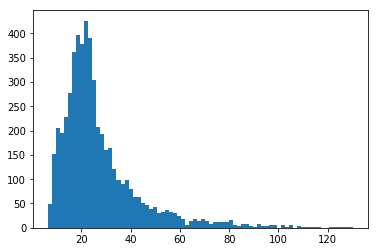

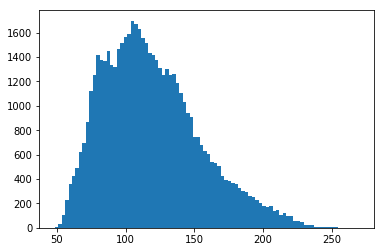

In [3]:
step_scores = []
angle_scores = []
for idx in range(train_images_z.shape[0]-1):
    train_image_z_1 =  train_images_z[idx, :]
    train_image_z_2 =  train_images_z[idx+1, :]
    train_step = train_steps[idx]
    train_angle = train_angles[idx]
    score = np.sum(np.power(np.subtract(train_image_z_1, train_image_z_2), 2))
    if train_step != 0:
        step_scores.append(score)
    if train_angle != 0:
        angle_scores.append(score)
        
plt.figure()
plt.hist(step_scores, bins='auto')
plt.figure()
plt.hist(angle_scores, bins='auto')

In [4]:
def find_match_list(image_list_z, max_idx, mini_score, max_score, find_image_z):
    end_idx = min(image_list_z.shape[0], max_idx)
    match_idx_list = []
    for idx in range(end_idx):
        score = np.sum(np.power(np.subtract(image_list_z[idx, :], find_image_z), 2))
        if score >= mini_score and score <= max_score:
            match_idx_list.append(idx)
    return match_idx_list

cell_list = [i for i in range(train_images_z.shape[0])]
head_cell_uf = UnionFind(cell_list)
place_cell_uf = UnionFind(cell_list)

for idx in range(train_images_z.shape[0]):
    if idx % 1000 == 0:
        print(datetime.datetime.now().time(), ':', idx, ':head_cell', len(head_cell_uf.components()),
              'place_cell', len(place_cell_uf.components()))
    if idx != 0:
        train_step = train_steps[idx-1]
        train_angle = train_angles[idx-1]
        find_image_z = train_images_z[idx]
        if train_angle != 0:
            # find a list of match head direction cell
            best_match_list = find_match_list(train_images_z, idx, 0.0, 40.0, find_image_z)
            if len(best_match_list) != 0:
                for best_match_idx in best_match_list:
                    head_cell_uf.union(idx, best_match_idx)
            # set the place cell the same as the previous image
            place_cell_uf.union(idx, idx-1)
        elif train_step != 0:
            # find a list of match place cell
            match_list = find_match_list(train_images_z, idx, 0.0, 10.0, find_image_z)
            if len(match_list) != 0:
                for match_idx in match_list:
                    component_list = place_cell_uf.component(match_idx)
                    is_unify = True
                    for component_idx in component_list:
                        if head_cell_uf.connected(component_idx, match_idx):
                            if np.sum(np.power(np.subtract(image_list_z[component_idx, :], image_list_z[idx, :]), 2)) > 30.0:
                                is_unify = False
                    if is_unify:
                        place_cell_uf.union(idx, match_idx)
            # set the head direction cell the same as the previous image
            head_cell_uf.union(idx, idx-1)
        else:
            print('ERROR!!!')

print('head_cell', len(head_cell_uf.components()), 'place_cell', len(place_cell_uf.components()))

22:20:26.495621 : 0 :head_cell 60000 place_cell 60000
22:20:48.485917 : 1000 :head_cell 59173 place_cell 59056
22:21:35.151138 : 2000 :head_cell 58421 place_cell 58107
22:22:46.744219 : 3000 :head_cell 57426 place_cell 57152
22:24:23.022610 : 4000 :head_cell 56265 place_cell 56171
22:26:25.699531 : 5000 :head_cell 55231 place_cell 55178
22:28:53.579470 : 6000 :head_cell 54421 place_cell 54208
22:31:51.953353 : 7000 :head_cell 53321 place_cell 53249
22:35:12.158014 : 8000 :head_cell 52373 place_cell 52278
22:38:59.059499 : 9000 :head_cell 51650 place_cell 51331
22:43:07.256884 : 10000 :head_cell 50542 place_cell 50366
22:47:42.214916 : 11000 :head_cell 49658 place_cell 49423
22:53:03.725650 : 12000 :head_cell 48582 place_cell 48457
22:58:58.506969 : 13000 :head_cell 47608 place_cell 47494
23:05:09.447852 : 14000 :head_cell 46733 place_cell 46539
23:11:39.668895 : 15000 :head_cell 45703 place_cell 45570
23:18:28.747689 : 16000 :head_cell 44719 place_cell 44589
23:25:52.173529 : 17000 :he

In [5]:
head_image_map = head_cell_uf.components()
head_cell_size = len(head_image_map)
image_head_map = np.zeros(train_images_z.shape[0])
head_cell_counter = 0
for image_list in head_image_map:
    for image_idx in image_list:
        image_head_map[image_idx] = head_cell_counter
    head_cell_counter += 1
print(head_cell_counter, 'head_cell_size:', head_cell_size)
    
place_image_map = place_cell_uf.components()
place_cell_size = len(place_image_map)
image_place_map = np.zeros(train_images_z.shape[0])
place_cell_counter = 0
for image_list in place_image_map:
    for image_idx in image_list:
        image_place_map[image_idx] = place_cell_counter
    place_cell_counter += 1
print(place_cell_counter, 'place_cell_size:', place_cell_size)

273 head_cell_size: 273
671 place_cell_size: 671


In [6]:
print(test_images_z.shape, train_images_z.shape)
head_cell_test_out = np.zeros((test_images_z.shape[0], head_cell_size))
place_cell_test_out = np.zeros((test_images_z.shape[0], place_cell_size))
print(head_cell_test_out.shape, place_cell_test_out.shape)

for test_image_z_idx in range(test_images_z.shape[0]):
    
    test_image_z = test_images_z[test_image_z_idx, :]
    image_dist_tmp = np.sum(np.power((train_images_z - test_image_z), 2), 1)
    mini_idx = np.argmin(image_dist_tmp)
    
    head_cell_idx = image_head_map[mini_idx]
#     print(mini_idx, head_cell_idx)
    head_cell_test_out[test_image_z_idx, int(head_cell_idx)] = 1
    
    place_cell_idx = image_place_map[mini_idx]
    place_cell_test_out[test_image_z_idx, int(place_cell_idx)] = 1
    
    if test_image_z_idx % 200 == 0:
        print(datetime.datetime.now().time(), ':', test_image_z_idx,
              'head_cell_idx:', head_cell_idx, 'place_cell_idx:', place_cell_idx)

(12096, 640) (60000, 640)
(12096, 273) (12096, 671)
11:58:00.924474 : 0 head_cell_idx: 138.0 place_cell_idx: 62.0
12:02:42.442091 : 200 head_cell_idx: 205.0 place_cell_idx: 169.0
12:07:39.531321 : 400 head_cell_idx: 134.0 place_cell_idx: 169.0
12:12:45.598270 : 600 head_cell_idx: 149.0 place_cell_idx: 653.0
12:17:35.030939 : 800 head_cell_idx: 130.0 place_cell_idx: 169.0
12:22:16.640174 : 1000 head_cell_idx: 123.0 place_cell_idx: 389.0
12:26:58.742805 : 1200 head_cell_idx: 101.0 place_cell_idx: 639.0
12:31:41.670559 : 1400 head_cell_idx: 142.0 place_cell_idx: 96.0
12:36:56.599615 : 1600 head_cell_idx: 200.0 place_cell_idx: 322.0
12:42:15.389829 : 1800 head_cell_idx: 138.0 place_cell_idx: 551.0
12:47:38.341068 : 2000 head_cell_idx: 17.0 place_cell_idx: 286.0
12:52:54.054847 : 2200 head_cell_idx: 134.0 place_cell_idx: 18.0
12:58:14.306944 : 2400 head_cell_idx: 209.0 place_cell_idx: 112.0
13:03:36.046738 : 2600 head_cell_idx: 130.0 place_cell_idx: 18.0
13:08:19.526602 : 2800 head_cell_idx

In [7]:
f = open('model/image_head_map.pickle', 'wb')
pickle.dump(image_head_map, f, pickle.HIGHEST_PROTOCOL)
f = open('model/image_place_map.pickle', 'wb')
pickle.dump(image_place_map, f, pickle.HIGHEST_PROTOCOL)

np.save('model/head_cell_test_out.npy', head_cell_test_out)
np.save('model/place_cell_test_out.npy', place_cell_test_out)

In [7]:
head_cell_test_out = np.load('model/head_cell_test_out.npy')
place_cell_test_out = np.load('model/place_cell_test_out.npy')
print(head_cell_test_out.shape, place_cell_test_out.shape)
head_cell_size = head_cell_test_out.shape[1]
place_cell_size = place_cell_test_out.shape[1]
print(head_cell_size, place_cell_size)

test_images = np.load('test_images.npy')
test_cmds = np.load('test_cmds.npy')
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
test_images_z = np.load('model/test_images_z.npy')
print(test_images.shape, test_cmds.shape, test_xs.shape, len(test_x_set), test_ys.shape, len(test_y_set),
      test_angles.shape, len(test_angle_set), test_images_z.shape)

(12096, 273) (12096, 1811)
273 1811
(12096, 40, 320, 1) (12096, 3) (12096,) 24 (12096,) 14 (12096,) 36 (12096, 640)


In [8]:
head_map_4_head_cell = np.zeros((36, head_cell_size))
place_map_4_head_cell = np.zeros((14, 24, head_cell_size))
head_map_4_place_cell = np.zeros((36, place_cell_size))
place_map_4_place_cell = np.zeros((14, 24, place_cell_size))

for test_image_z_idx in range(test_images_z.shape[0]):
    test_x = test_xs[test_image_z_idx]
    test_y = test_ys[test_image_z_idx]
    test_angle = test_angles[test_image_z_idx]
    head_map_4_head_cell[test_angle.astype(int), :] += head_cell_test_out[test_image_z_idx, :]
    place_map_4_head_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += head_cell_test_out[test_image_z_idx, :]
    head_map_4_place_cell[test_angle.astype(int), :] += place_cell_test_out[test_image_z_idx, :]
    place_map_4_place_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += place_cell_test_out[test_image_z_idx, :]

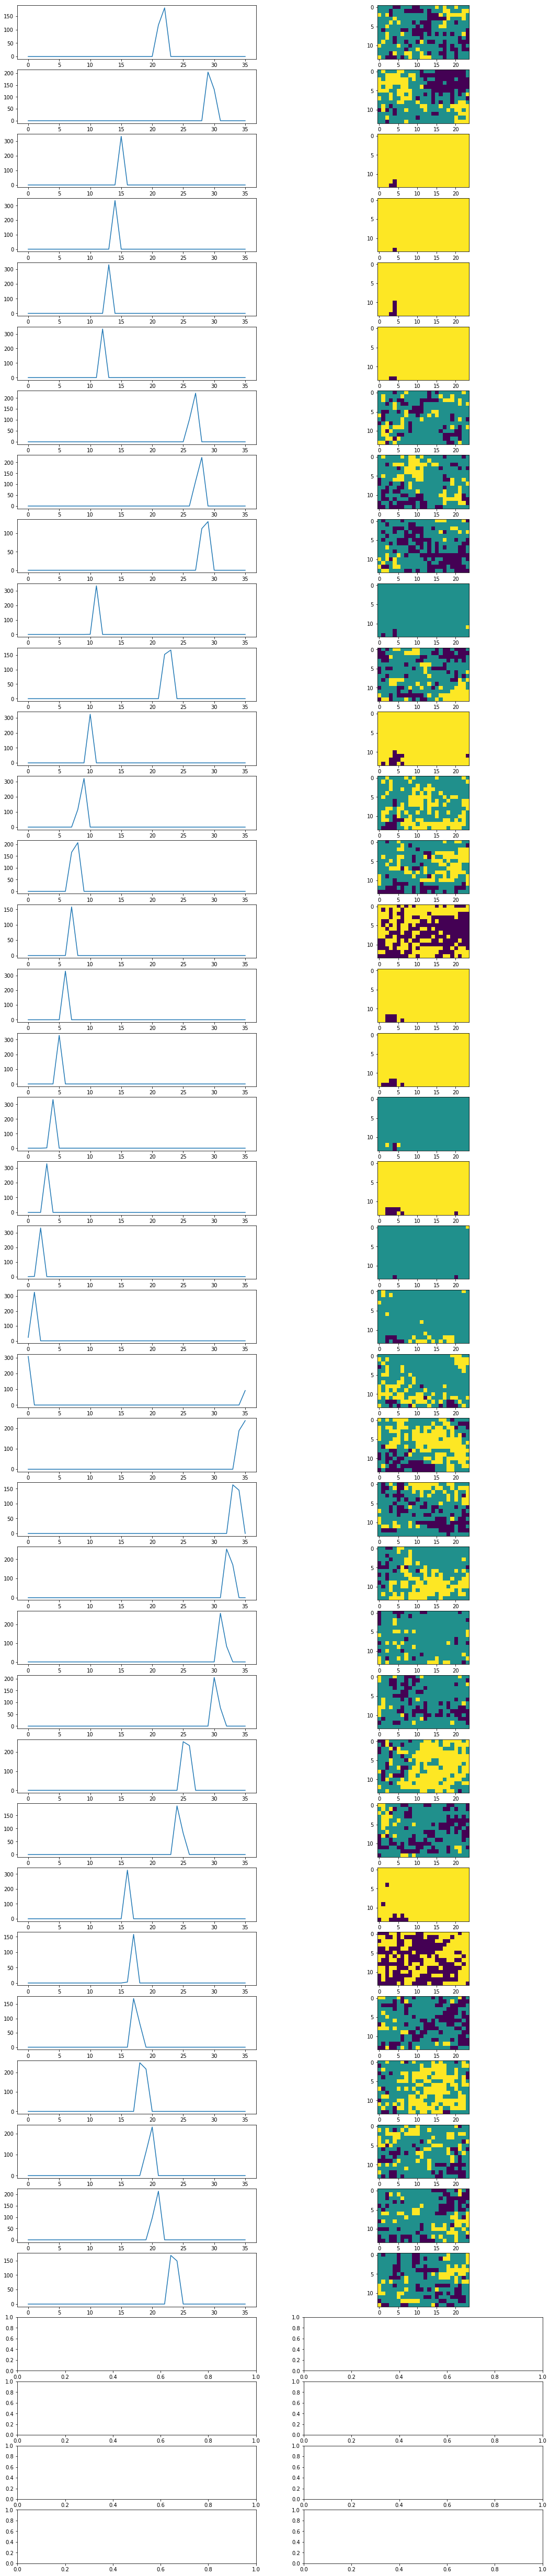

In [9]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
idx_counter = 0
for head_cell_idx in range(head_cell_size):
    if np.max(head_map_4_head_cell[:, head_cell_idx]) >= 30 and idx_counter < 40:
        axs[idx_counter][0].plot(np.abs(head_map_4_head_cell[:, head_cell_idx]))
    #     axs[idx_counter][0].set_ylim(0, 20)
        axs[idx_counter][1].imshow(np.abs(place_map_4_head_cell[:, :, head_cell_idx]))
        idx_counter += 1
plt.show()

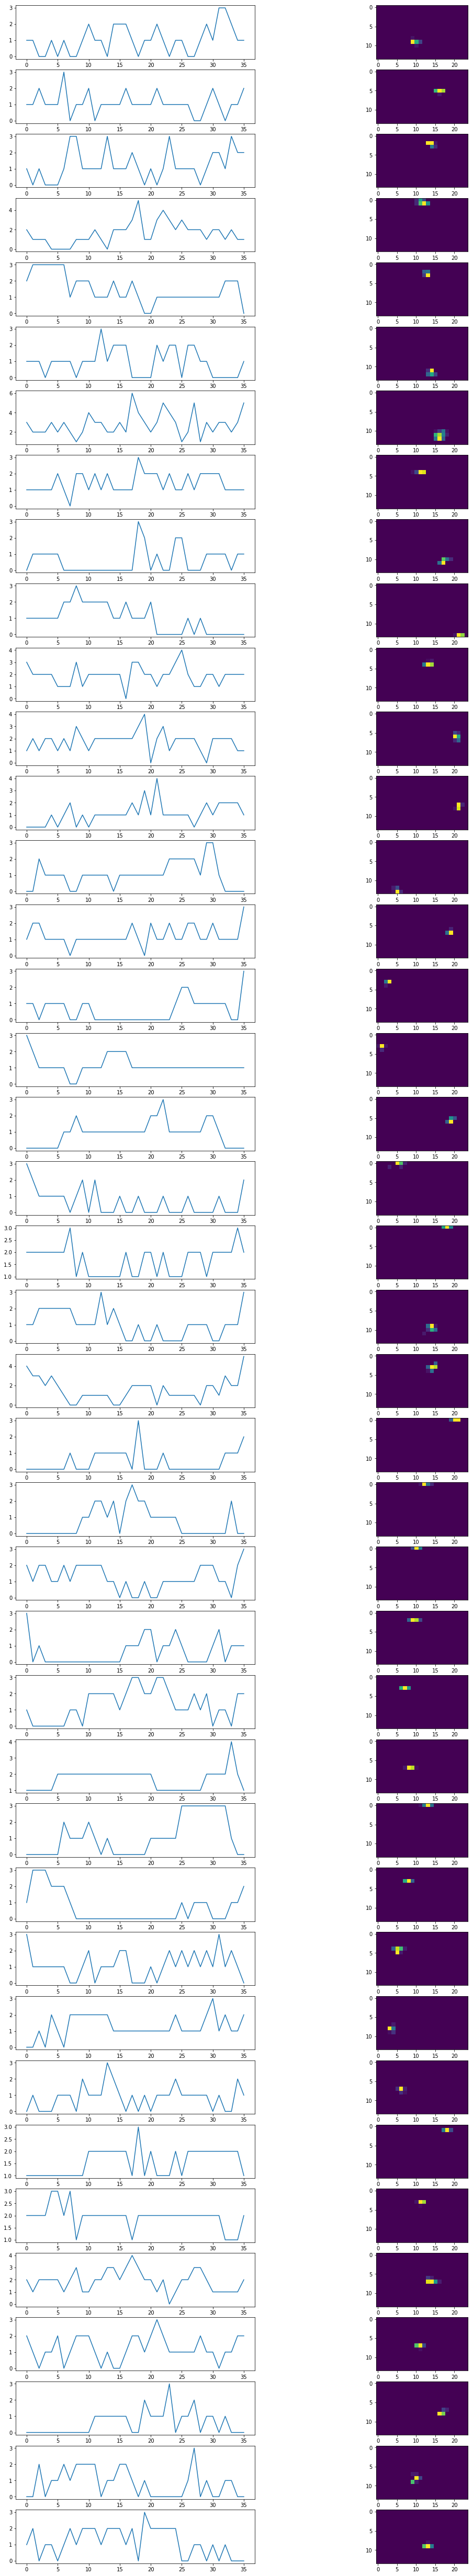

In [12]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
idx_counter = 0
for place_cell_idx in range(place_cell_size):
    if np.max(head_map_4_place_cell[:, place_cell_idx]) >= 3 and idx_counter < 40:
        axs[idx_counter][0].plot(np.abs(head_map_4_place_cell[:, place_cell_idx]))
    #     axs[idx_counter][0].set_ylim(0, 20)
        axs[idx_counter][1].imshow(np.abs(place_map_4_place_cell[:, :, place_cell_idx]))
        idx_counter += 1
plt.show()